## Import the libraries

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM,Bidirectional,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

## Load the dataset

In [14]:
train=pd.read_csv('/content/train.txt',names=["text","emotions"],sep=';') #orginal dataframes
test=pd.read_csv('/content/test.txt',names=["text","emotions"],sep=';') #orginal dataframes
val=pd.read_csv("/content/val.txt",names=["text","emotions"],sep=';')#orginal dataframes

In [15]:
display(train.sample(2))
display(test.sample(2))
display(val.sample(2))

,text,emotions
4977,i could continue feeling awful and crying to a...,sadness
14379,i hate feeling like this im always getting mad...,anger


,text,emotions
1769,i feel myself about how successful my attempts...,joy
101,i journaled about my tendency to sometimes ove...,sadness


,text,emotions
504,i seem to feel some fondness for this curious ...,surprise
67,i try to share what i bake with a lot of peopl...,love


In [16]:
print(f"The shape of train data is {train.shape}")
print(f"The shape of test data is {test.shape}")
print(f"The shape of val data is {val.shape}")

The shape of train data is (16000, 2)
The shape of test data is (2000, 2)
The shape of val data is (2000, 2)


## Exploratory Data Analysis

In [17]:
def class_count(df):
  emotions=df["emotions"].value_counts()
  print(emotions)

  plt.figure(figsize=(10,5))
  sns.barplot(x=emotions.index,y=emotions.values,palette="rocket")
  plt.title("Emotions Count")
  plt.show()


emotions
joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: count, dtype: int64


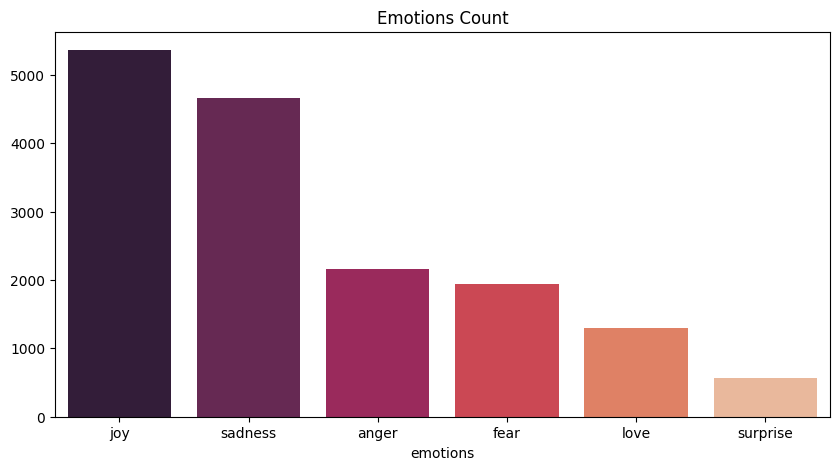

In [18]:
class_count(train)

emotions
joy         695
sadness     581
anger       275
fear        224
love        159
surprise     66
Name: count, dtype: int64


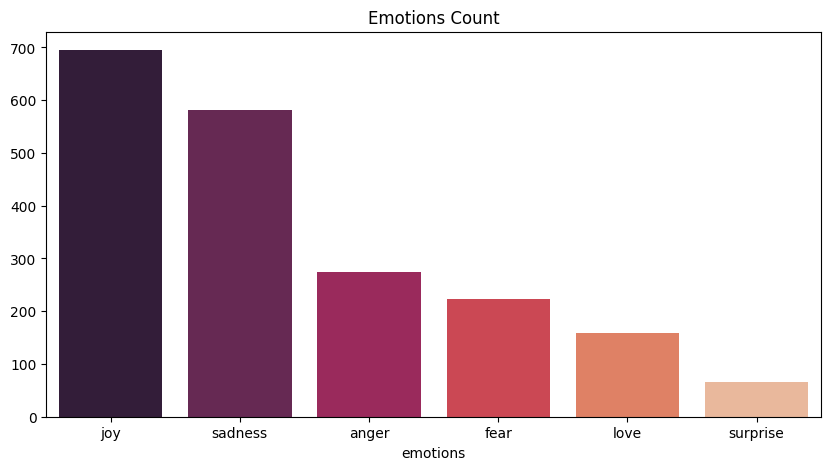

In [19]:
class_count(test)

emotions
joy         704
sadness     550
anger       275
fear        212
love        178
surprise     81
Name: count, dtype: int64


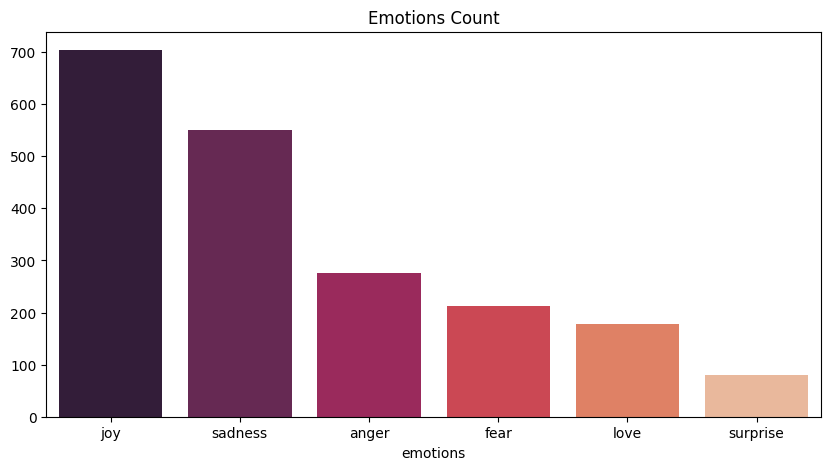

In [20]:
class_count(val)

### generated dataframes

Let's now import the data that was generated using our custom sequence-to-sequence model in the [Text Generation Notebook](https://github.com/bhanuprakash-321/Sentiment-Analysis-and-Emotion-Conditioned-Text-Generation-Using-Deep-Learning/blob/main/.ipynb%20files/Text_Generation.ipynb).  
This synthetic data was created to balance the dataset by adding meaningful and diverse samples to the underrepresented emotion classes.

In [21]:
surprise=pd.read_csv('/content/surprise_texts.csv')
love=pd.read_csv('/content/love_texts.csv')
fear=pd.read_csv('/content/fear_texts.csv')
anger=pd.read_csv('/content/anger_texts.csv')
sadness=pd.read_csv('/content/sadness_texts.csv')

In [22]:
display(surprise.shape)
display(love.shape)
display(fear.shape)
display(anger.shape)
display(sadness.shape)

(6042, 2)

(5120, 2)

(4388, 2)

(4052, 2)

(964, 2)

In [23]:
import pandas as pd
import numpy as np

def balance_emotions(train, test, val, joy_class='joy'):
    # Get the number of joy samples in each dataset
    joy_train_count = train[train['emotions'] == joy_class].shape[0]
    joy_test_count = test[test['emotions'] == joy_class].shape[0]
    joy_val_count = val[val['emotions'] == joy_class].shape[0]

    # List of other emotions to balance
    other_emotions = ['surprise', 'love', 'fear', 'anger', 'sadness']

    # Generate more samples for each emotion based on joy counts
    for emotion in other_emotions:
        # Load corresponding emotion dataset
        emotion_data = pd.read_csv(f'/content/{emotion}_texts.csv')

        # Get the number of samples for the current emotion in each dataset
        emotion_train_count = train[train['emotions'] == emotion].shape[0]
        emotion_test_count = test[test['emotions'] == emotion].shape[0]
        emotion_val_count = val[val['emotions'] == emotion].shape[0]

        # Number of texts needed to balance
        train_needed = joy_train_count - emotion_train_count
        test_needed = joy_test_count - emotion_test_count
        val_needed = joy_val_count - emotion_val_count

        # Add more samples to the train, test, and val datasets as needed
        if train_needed > 0:
            # Sample and add new texts to train set
            new_train_data = emotion_data.sample(n=train_needed, replace=True, random_state=42)
            new_train_data['emotions'] = emotion
            train = pd.concat([train, new_train_data], ignore_index=True)

        if test_needed > 0:
            # Sample and add new texts to test set
            new_test_data = emotion_data.sample(n=test_needed, replace=True, random_state=42)
            new_test_data['emotions'] = emotion
            test = pd.concat([test, new_test_data], ignore_index=True)

        if val_needed > 0:
            # Sample and add new texts to val set
            new_val_data = emotion_data.sample(n=val_needed, replace=True, random_state=42)
            new_val_data['emotions'] = emotion
            val = pd.concat([val, new_val_data], ignore_index=True)

    # Return the balanced datasets
    return train, test, val

# Example usage:
train_bal, test_bal, val_bal = balance_emotions(train, test, val)


This function balance_emotions() is used to balance the number of samples across all emotion classes in the train, test, and validation datasets. It ensures that each emotion has the same number of samples as the dominant class (e.g., "joy") by adding synthetic texts generated using a text generation model. This helps prevent class imbalance issues and improves model performance during training and evaluation.

emotions
sadness     5362
anger       5362
love        5362
surprise    5362
fear        5362
joy         5362
Name: count, dtype: int64


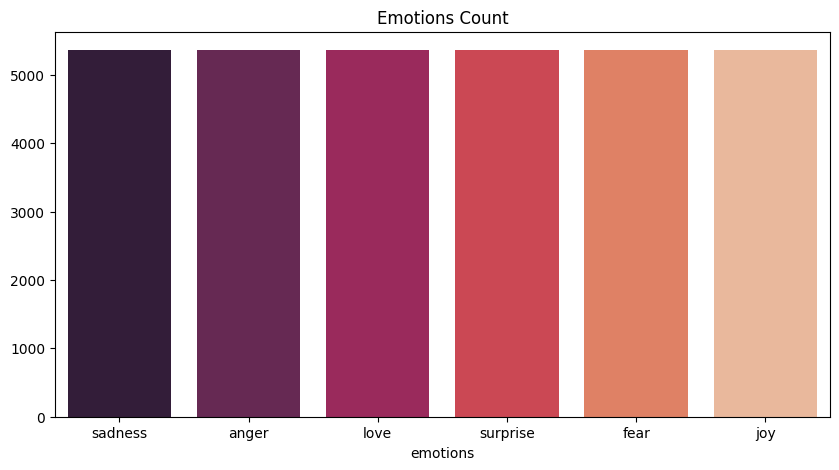

In [24]:
class_count(train_bal)

emotions
sadness     695
joy         695
fear        695
anger       695
love        695
surprise    695
Name: count, dtype: int64


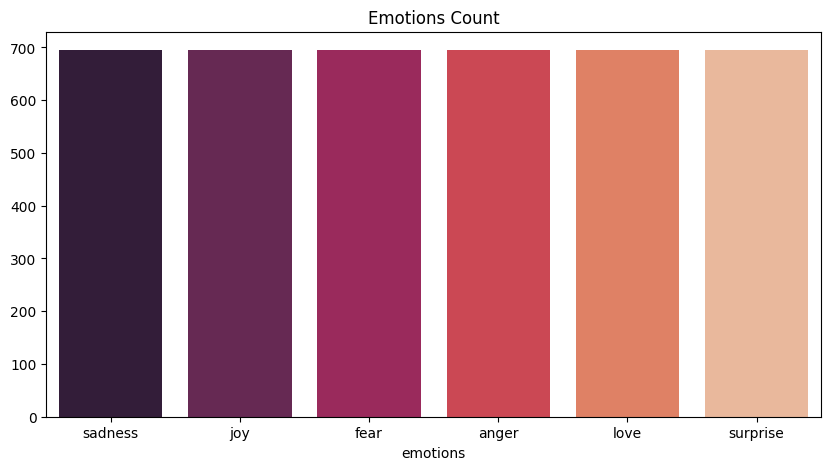

In [25]:
class_count(test_bal)

emotions
sadness     704
love        704
anger       704
joy         704
fear        704
surprise    704
Name: count, dtype: int64


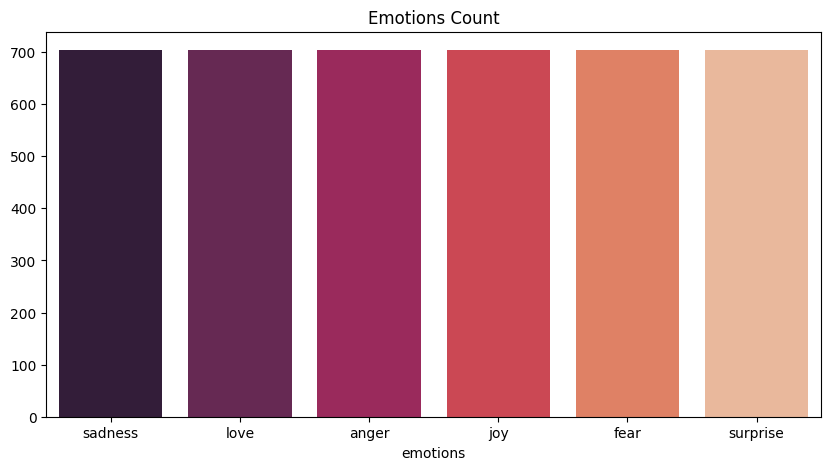

In [26]:
class_count(val_bal)

AS you can see that all our emotion classes were equally balanced.

## Preprocessing

In [ ]:
import re

def clean_text(text):
    text = text.lower()                              # Lowercase
    text = re.sub(r"[^a-zA-Z\s]", "", text)          # Remove punctuation/numbers
    text = re.sub(r"\s+", " ", text).strip()         # Remove extra spaces
    return text

In [ ]:
train_bal["text"]=train_bal["text"].apply(clean_text)
test_bal["text"]=test_bal["text"].apply(clean_text)
val_bal["text"]=val_bal["text"].apply(clean_text)

## Tokenization and Padding

Tokenization breaks text into smaller units like words or subwords so models can understand them. Padding makes all input sequences the same length for efficient batch processing in models

In [ ]:
# Tokenization
tokenizer = Tokenizer(num_words=5000) # Vocabulary size
tokenizer.fit_on_texts(train_bal['text'])

train_bal_sequences = tokenizer.texts_to_sequences(train_bal['text'])
val_bal_sequences = tokenizer.texts_to_sequences(val_bal['text'])

# Padding
max_length = 60  # Maximum sequence length
train_bal_padded = pad_sequences(train_bal_sequences, maxlen=max_length, padding='post', truncating='post')
val_bal_padded = pad_sequences(val_bal_sequences, maxlen=max_length, padding='post', truncating='post')

## Split the data

In [ ]:
# Split the data into features (X) and target (y)
X_train = train_bal_padded
y_train = train_bal['emotions']
X_val = val_bal_padded
y_val = val_bal['emotions']


## Encoding Target Labels Using LabelEncoder

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)

The `LabelEncoder` converts categorical emotion labels into numeric form so machine learning models can process them. It fits on the training labels and transforms both training and validation labels consistently.

## model building

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=256, input_length=max_length)) # Increased embedding dimension
model.add(Bidirectional(LSTM(256, return_sequences=True))) # Increased LSTM units
model.add(Dropout(0.5)) # Increased dropout for regularization
model.add(Bidirectional(LSTM(128))) # Added another Bidirectional LSTM layer
model.add(Dropout(0.5)) # Dropout after the second LSTM layer
model.add(Dense(64, activation='relu')) # Added a dense layer with ReLU activation
model.add(Dropout(0.3)) # Dropout before the output layer
model.add(Dense(6, activation='softmax'))

optimizer = Adam(learning_rate=3e-4) # Slightly increased learning rate
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

# Training with early stopping and increased epochs
history = model.fit(X_train, y_train,
                    epochs=30,  # Increased epochs
                    batch_size=64,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping]) # Added early stopping

# Evaluate the model
loss, accuracy = model.evaluate(X_val, y_val)
print(f"Validation accuracy: {accuracy*100:.2f}%")



Epoch 1/30
503/503 ━━━━━━━━━━━━━━━━━━━━ 21s 29ms/step - accuracy: 0.4826 - loss: 1.2507 - val_accuracy: 0.7976 - val_loss: 0.5529
Epoch 2/30
503/503 ━━━━━━━━━━━━━━━━━━━━ 21s 30ms/step - accuracy: 0.8279 - loss: 0.4945 - val_accuracy: 0.9160 - val_loss: 0.2746
Epoch 3/30
503/503 ━━━━━━━━━━━━━━━━━━━━ 21s 30ms/step - accuracy: 0.9286 - loss: 0.2266 - val_accuracy: 0.9373 - val_loss: 0.1825
Epoch 4/30
503/503 ━━━━━━━━━━━━━━━━━━━━ 20s 29ms/step - accuracy: 0.9639 - loss: 0.1169 - val_accuracy: 0.9439 - val_loss: 0.1762
Epoch 5/30
503/503 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - accuracy: 0.9734 - loss: 0.0876 - val_accuracy: 0.9470 - val_loss: 0.1676
Epoch 6/30
503/503 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - accuracy: 0.9800 - loss: 0.0660 - val_accuracy: 0.9500 - val_loss: 0.1621
Epoch 7/30
503/503 ━━━━━━━━━━━━━━━━━━━━ 21s 30ms/step - accuracy: 0.9832 - loss: 0.0537 - val_accuracy: 0.9517 - val_loss: 0.1735
Epoch 8/30
503/503 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - accuracy: 0.9857 - loss: 0.0463 - 

We used the same sequential model architecture from the [sentiment analysis without text generation notebook](https://github.com/bhanuprakash-321/Sentiment-Analysis-and-Emotion-Conditioned-Text-Generation-Using-Deep-Learning/blob/main/.ipynb%20files/sentiment_analysis_without_text_generation_.ipynb) to evaluate the impact of the balanced dataset.

## Model Evaluation

132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Accuracy: 0.9559659090909091
Precision: 0.9559154972695312
Recall: 0.9559659090909091
F1 Score: 0.9559316670921221


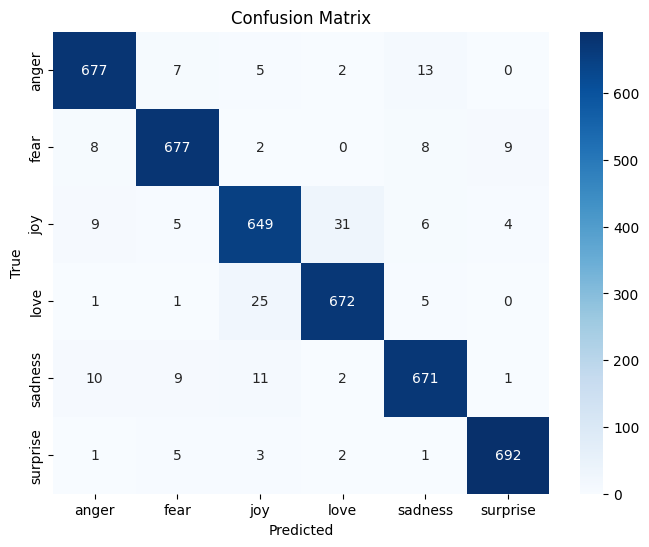

In [ ]:
# Make predictions on the validation set
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate metrics
accuracy = accuracy_score(y_val, y_pred_classes)
precision = precision_score(y_val, y_pred_classes, average='weighted')
recall = recall_score(y_val, y_pred_classes, average='weighted')
f1 = f1_score(y_val, y_pred_classes, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Create confusion matrix
cm = confusion_matrix(y_val, y_pred_classes)

# Plot confusion matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


## Result:
After augmenting the dataset with synthetically generated emotion-specific texts, the **validation accuracy increased from 91% to 95%**, clearly indicating the effectiveness of this approach in handling class imbalance and improving generalization.

Let's now test on the test data.

## Test Data

131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Test Accuracy: 0.9522781774580336
Test Precision: 0.9524175891797747
Test Recall: 0.9522781774580336
Test F1 Score: 0.9522999603229121


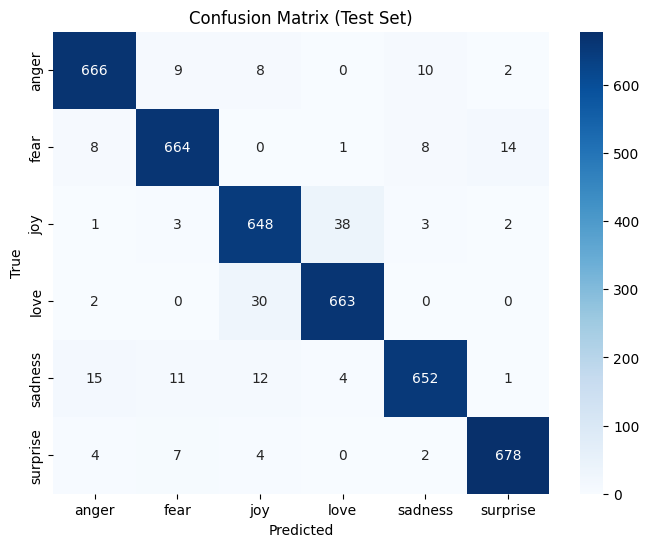

In [ ]:
# Preprocess the test data
test_sequences = tokenizer.texts_to_sequences(test_bal['text'])
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='post')

# Make predictions on the test set
y_pred_test = model.predict(test_padded)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)

# Convert the predicted classes back to emotion labels
y_pred_test_labels = le.inverse_transform(y_pred_test_classes)

# Calculate metrics for the test set
y_true_test = le.transform(test_bal['emotions'])  # Encode true labels
accuracy_test = accuracy_score(y_true_test, y_pred_test_classes)
precision_test = precision_score(y_true_test, y_pred_test_classes, average='weighted')
recall_test = recall_score(y_true_test, y_pred_test_classes, average='weighted')
f1_test = f1_score(y_true_test, y_pred_test_classes, average='weighted')

print(f"Test Accuracy: {accuracy_test}")
print(f"Test Precision: {precision_test}")
print(f"Test Recall: {recall_test}")
print(f"Test F1 Score: {f1_test}")

# Create confusion matrix for the test set
cm_test = confusion_matrix(y_true_test, y_pred_test_classes)

# Plot confusion matrix as heatmap for the test set
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Test Set)")
plt.show()


After augmenting the dataset with synthetically generated emotion-specific texts, the **test accuracy improved from 90% to 95%,** clearly demonstrating the effectiveness of this approach in addressing class imbalance and enhancing model generalization.

**Additionally,** the values in the confusion matrix have shown noticeable improvement, especially for underrepresented classes, due to the inclusion of diverse and balanced synthetic samples.

## Conlusion:
- The project successfully demonstrates the effectiveness of data augmentation using synthetic text generation to address class imbalance in an emotion detection task.
- By balancing the dataset, the model's performance significantly improved, with **validation accuracy increasing from 91% to 95% and test accuracy improving from 90% to 95%.**
- The improved confusion matrices for both validation and test sets further highlight the model's enhanced ability to correctly classify examples from previously underrepresented emotion categories.
- This indicates that generating synthetic data for minority classes is a valuable technique for boosting performance and generalization in text classification problems with imbalanced datasets.